# Foursquare Venue Types and Names As Proxies for Geography

### Abstract

Problem: 

The United States is often thought as having two main cultural divisions based on whether states are in the South or North. If we observe the country from a topographical perspective, however, it is apparent that west of the a 104 longitude, the terrain is much more mountainous. The Eastern part of the country is mostly flat, with an exception of the relatively hilly Appalachian terrain. Terrain influences the types of activities people engage in, and thus affects culture. In choosing where to live, it is important to know what kind of lifestyle one wants. In this particular exercise, we want to find out if venue types and names are a reflection of geography, and whether this influence is strongest East to West or North to South.

Methodology:

Apply the OSEMN Model for Data Science Projects.

Using Foursquare, we extracted venue information for a set of venue types that are of personal interest. 

Eastern US is defined as all states and cities right of the 104 longitude, and the Western US to the left of the same line. Similarly, the Northern US is defined as all regions at and above the 37 latitude.

By extracting these attributes for major cities accross the United States, we created a dataset with over 40 thousand samples. Then, we created categorical variables for each venue type (park, trail, museum, etc), and also for each word in the venue names. 

A simple logistic regression model was set up to determine whether the predictive power of using venue types and names was strongest N-S or E-W.

Findings: 

With minimal feature engineering and data cleaning, the predictive power of venue types and names is stronger to distinguish the West from the Eastern US than it is to distinguish the South from the Northern US. 

### Technical Analysis

#### Step 1: Obtain Data

Import relevant libraries

In [58]:
import pandas as pd
import numpy as np
import requests

import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors

#!pip install --upgrade pip
#!pip install plotly==4.1.0
#!pip install "notebook>=5.3" "ipywidgets>=7.2"
import plotly
#import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
%matplotlib inline

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from pandas.io.html import read_html
from sklearn.cluster import KMeans # import k-means from clustering stage

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries imported.')

Libraries imported.


Create a list with cities of interest accross the United States.

In [2]:
# Cities list
cities = ['Houston, TX','Austin, TX','Dallas, TX','San Antonio, TX','Fort Worth, Texas','San Francisco, CA','San Jose, CA','Santa Rosa, CA','Palo Alto, CA','Los Angeles, CA','Santa Barbara, CA',
          'San Diego, CA','Long Beach, CA','Palmdale, CA','Bakersfield, CA','Fresno, CA','Seattle, WA','Portland,OR','Miami, FL','Orlando, FL','Atlanta, GA','New Orleans, LA','Grand Junction, CO',
          'Denver, CO','Colorado Springs, CO','New York, NY', 'Arlington, VA','Anchorage, AK','Sacramento, CA','Tampa, FL','Des Moines, IA','Reno, NV','Las Vegas, NV',
          'Chicago, IL','Detroit, MI','Boston, MA','New Haven, CT', 'St. Louis, MO','Phoenix, AZ','Albuquerque, NM','Oklahoma City, OK']

Identify Venue Categories to Extract From Foursquare.

In [3]:
#Outdoors and Recreation Venues: Trails, Bike Trail, Botanical Gardens, Forest, Mountain, Nature Preserve, National Park
outdoors_venues_ID = ['4bf58dd8d48988d159941735','56aa371be4b08b9a8d57355e','52e81612bcbc57f1066b7a22','52e81612bcbc57f1066b7a23','4eb1d4d54b900d56c88a45fc','52e81612bcbc57f1066b7a13','52e81612bcbc57f1066b7a21']
                      
# Professional & Other Places:  Tech Startup, Convention Center, Observatory
professional_venues_ID = ['4bf58dd8d48988d125941735','4bf58dd8d48988d1ff931735','5744ccdfe4b0c0459246b4d9']
    
#cultural venues:  Spiritual Center: Buddhist Temple, Hindu Temple, Synagoge, Winery
cultural_venues_ID = ['52e81612bcbc57f1066b7a3e','52e81612bcbc57f1066b7a3f','4bf58dd8d48988d139941735','4bf58dd8d48988d14b941735']

# Food and drink shop: Farmers Market, Health Food Store, Organic Grocery, Fruit and Vegetable Store, Juice Bar
food_venues_ID = ['4bf58dd8d48988d1fa941735','50aa9e744b90af0d42d5de0e','52f2ab2ebcbc57f1066b8b45','52f2ab2ebcbc57f1066b8b1c','4bf58dd8d48988d112941735']

# Beautification: Park, Flower Shop, Art Studio
beauty_venues_ID = ['4bf58dd8d48988d163941735','4bf58dd8d48988d11b951735','58daa1558bbb0b01f18ec1d6']

# store all ids in a list
categoryIDs = [outdoors_venues_ID,professional_venues_ID,cultural_venues_ID,food_venues_ID,beauty_venues_ID]

Create a Function to Connect and Extract Data from Foursquare

In [4]:
# This function connects to Foursquare and extracts venues matching a CategoryID and 
# stores them in the dataframe designated.

def getFoursquareCityData(cities, categoryIDs, limit, max_radius):

    # Connect to Foursquare and Query each city to find the number of each venue.

    client_ID = ''
    client_secret = ''
    version = '20180605' # Foursquare API version

    #print('Your credentails:')
    #print('CLIENT_ID: ' + client_ID)
    #print('CLIENT_SECRET:' + client_secret)

    venues_list = []
    venues_df = pd.DataFrame(columns = ['City','CategoryID','Venue','Latitude','Longitude','Type'])
    
    for city in cities:
        for list in categoryIDs:
            for category in list:
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}&categoryId={}'.format(
                    client_ID,
                    client_secret,
                    version,
                    city,
                    max_radius,
                    limit,
                    category)

                city_abr = city.upper()[:3]
                try:
                    venues = requests.get(url).json()['response']['groups'][0]['items']

                    venues_list.append([(
                    city,
                    category,
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],
                    v['venue']['categories'][0]['name']) for v in venues])
                except IndexError:
                    continue
                except KeyError:
                    continue

            venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        print(city_abr + " records extracted.")
    print("The size of your venue dataframe is:")
    print(venues_df.shape)
    return venues_df

Execute function and populate the venues dataframe with the raw data.

In [12]:
# Find venues near each city center around a 50 km radius (around 30 miles). Limit each venue list to 100 distinct venues
venues_df = getFoursquareCityData(cities, categoryIDs, 100, 100000)

HOU records extracted.
AUS records extracted.
DAL records extracted.
SAN records extracted.
FOR records extracted.
SAN records extracted.
SAN records extracted.
SAN records extracted.
PAL records extracted.
LOS records extracted.
SAN records extracted.
SAN records extracted.
LON records extracted.
PAL records extracted.
BAK records extracted.
FRE records extracted.
SEA records extracted.
POR records extracted.
MIA records extracted.
ORL records extracted.
ATL records extracted.
NEW records extracted.
GRA records extracted.
DEN records extracted.
COL records extracted.
NEW records extracted.
ARL records extracted.
ANC records extracted.
SAC records extracted.
TAM records extracted.
DES records extracted.
REN records extracted.
LAS records extracted.
CHI records extracted.
DET records extracted.
BOS records extracted.
NEW records extracted.
ST. records extracted.
PHO records extracted.
ALB records extracted.
OKL records extracted.
The size of your venue dataframe is:
(44006, 6)


Preview venues dataframe

In [13]:
venues_df.head()

,0,1,2,3,4,5
0,"Houston, TX",4bf58dd8d48988d159941735,Memorial Park 3 Mile Trail,29.770968,-95.435477,Trail
1,"Houston, TX",4bf58dd8d48988d159941735,Buffalo Bayou Walk,29.762177,-95.375844,Trail
2,"Houston, TX",4bf58dd8d48988d159941735,Buffalo Bayou Park,29.762068,-95.391626,Park
3,"Houston, TX",4bf58dd8d48988d159941735,White Oak Bayou Trail,29.786578,-95.417864,Trail
4,"Houston, TX",4bf58dd8d48988d159941735,Rice Running Trail,29.721954,-95.412069,Trail


#### Step 2. Scrub Data

Rename columns

In [14]:
venues_df.columns = ['City','CategoryID','Venue','Latitude','Longitude','Type']

Create binary label columns for East-West and North-South

In [319]:
# Label South and North cities

venues_df['North'] = venues_df.Latitude.map(lambda x: 0 if x < 37 else 1)
venues_df['West'] = venues_df.Longitude.map(lambda x: 0 if x > -104 else 1)

Remove duplicates

In [18]:
#Drop Duplicates!
venues_df = venues_df.drop_duplicates()
print('This is the size of the dataframe after dropping duplicates')
venues_df.shape

This is the size of the dataframe after dropping duplicates


(44003, 7)

Lower case and split venue names text into tokens.
Preview dataframe.

In [248]:
venues_df['Venue_tokens'] = venues_df.Venue.map(lambda x: x.lower().split(' '))

In [249]:
venues_df.head()

,City,CategoryID,Venue,Latitude,Longitude,Type,North,Venue_tokens,West
0,"Houston, TX",4bf58dd8d48988d159941735,Memorial Park 3 Mile Trail,29.770968,-95.435477,Trail,0,"[memorial, park, 3, mile, trail]",0
1,"Houston, TX",4bf58dd8d48988d159941735,Buffalo Bayou Walk,29.762177,-95.375844,Trail,0,"[buffalo, bayou, walk]",0
2,"Houston, TX",4bf58dd8d48988d159941735,Buffalo Bayou Park,29.762068,-95.391626,Park,0,"[buffalo, bayou, park]",0
3,"Houston, TX",4bf58dd8d48988d159941735,White Oak Bayou Trail,29.786578,-95.417864,Trail,0,"[white, oak, bayou, trail]",0
4,"Houston, TX",4bf58dd8d48988d159941735,Rice Running Trail,29.721954,-95.412069,Trail,0,"[rice, running, trail]",0


Create binary categorical variables for each token in the venue name for each venue type

In [289]:
from sklearn.preprocessing import MultiLabelBinarizer

groups = venues_df.Venue_tokens

mlb = MultiLabelBinarizer()

dummies = pd.DataFrame(mlb.fit_transform(groups),columns=mlb.classes_, index=venues_df.index)

Export datasets to use later

In [298]:
venues_df.to_csv('Venues.csv')
dummies.to_csv('Dummies.csv')

# get dummies for Venue Type
venue_type_dummies = pd.get_dummies(venues_df.Type)
#join1 = venues_df.join(dummies)
join2 = join1.join(venue_type_dummies, rsuffix='_typ')
join2.to_csv('Dataset.csv')

#### Step 3: Explore Data

Read data back in

In [9]:
join2 = pd.read_csv('Dataset.csv')
join2['West'] = join2.Longitude.map(lambda x: 0 if x > -104 else 1)

In [10]:
df = pd.read_csv('Venues.csv')

Prepare the data for plotting.
Create various slices of the data for input in a horizontal bar chart.

In [11]:
# Create dataframes for each venue category

outdoors_df = df.loc[df['CategoryID'].isin(outdoors_venues_ID)]
startups_df = df.loc[df['CategoryID'].isin(professional_venues_ID)]
cultural_df = df.loc[df['CategoryID'].isin(cultural_venues_ID)]
food_df = df.loc[df['CategoryID'].isin(food_venues_ID)]
beauty_df = df.loc[df['CategoryID'].isin(beauty_venues_ID)]


In [13]:
venues_count = pd.DataFrame(df.groupby('City').count()['Venue'])
venues_count = venues_count.sort_values(by=['Venue'])
venues_count = venues_count.reset_index()
max_number = venues_count['Venue'].max()
max_city = venues_count.iloc[venues_count['Venue'].idxmax()][0]
min_number = venues_count['Venue'].min()
min_city = venues_count.iloc[venues_count['Venue'].idxmin()][0]
cities = list(venues_count['City'])

In [14]:
# Count the numbers of venues in each category.
outdoors_count = pd.DataFrame(outdoors_df.groupby('City').count()['Venue'])
outdoors_count = outdoors_count.reindex(venues_count['City'])
startups_count = pd.DataFrame(startups_df.groupby('City').count()['Venue'])
startups_count = startups_count.reindex(venues_count['City'])
cultural_count = pd.DataFrame(cultural_df.groupby('City').count()['Venue'])
cultural_count = cultural_count.reindex(venues_count['City'])
food_count = pd.DataFrame(food_df.groupby('City').count()['Venue'])
food_count = food_count.reindex(venues_count['City'])
beauty_count = pd.DataFrame(beauty_df.groupby('City').count()['Venue'])
beauty_count = beauty_count.reindex(venues_count['City'])


In [16]:
# Create a function to count how many of each category are present per city

def makeList(cities, count_df):
    N = len(cities)
    count_list = []
    for index in range(0,N):
        city_total = count_df.iloc[index][0]
        count_list.append(city_total)
    return count_list


In [17]:
# Apply the function to create lists of total venues per category
outdoors_count_list = makeList(cities, outdoors_count)
startups_count_list = makeList(cities, startups_count)
cultural_count_list = makeList(cities, cultural_count)
food_count_list = makeList(cities, food_count)
beauty_count_list = makeList(cities, beauty_count)


# YOU HAVE TO ORDER THIS DATAFRAME BY THE ORDER OF VENUE_COUNT

Create Visualizations

In [59]:
#!pip install chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go

py.sign_in('','')

In [60]:


trace1 = go.Bar(
    y= cities[0:20],
    x= outdoors_count_list[0:20],
    name='Outdoors',
    orientation = 'h',
    marker = dict(
        color = 'rgba(73,124,81,0.8)',
    )
)
trace2 = go.Bar(
    y= cities[0:20],
    x= startups_count_list[0:20],
    name='Startups',
    orientation = 'h',
    marker = dict(
        color = 'rgba(81,73,124,0.8)'
   )
)
trace3 = go.Bar(
    y= cities[0:20],
    x= cultural_count_list[0:20],
    name='Cultural',
    orientation = 'h',
    marker = dict(
        color = 'rgba(124,73,116,0.8)',
   )
)
trace4 = go.Bar(
    y= cities[0:20],
    x= food_count_list[0:20],
    name='Food',
    orientation = 'h',
    marker = dict(
        color = 'rgba(139,115,95,0.8)',
    )
)
trace5 = go.Bar(
    y= cities[0:20],
    x= beauty_count_list[0:20],
    name='Beauty',
    orientation = 'h',
    marker = dict(
        color = 'rgba(95,119,139,0.8)',
    )
)       
data = [trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    barmode='stack', title = 'Foursquare Venue Categories in U.S. Cities',xaxis=dict(range=[0, 1800]))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='marker-h-bar')

In [61]:

tracea = go.Bar(
    y= cities[20:42],
    x= outdoors_count_list[20:42],
    name='Outdoors',
    orientation = 'h',
    marker = dict(
        color = 'rgba(73,124,81,0.8)',
    )
)
traceb = go.Bar(
    y= cities[20:42],
    x= startups_count_list[20:42],
    name='Startups',
    orientation = 'h',
    marker = dict(
        color = 'rgba(81,73,124,0.8)'
   )
)
tracec = go.Bar(
    y= cities[20:42],
    x= cultural_count_list[20:42],
    name='Cultural',
    orientation = 'h',
    marker = dict(
        color = 'rgba(124,73,116,0.8)',
   )
)
traced = go.Bar(
    y= cities[20:42],
    x= food_count_list[20:42],
    name='Food',
    orientation = 'h',
    marker = dict(
        color = 'rgba(139,115,95,0.8)',
    )
)
tracee = go.Bar(
    y= cities[20:42],
    x= beauty_count_list[20:42],
    name='Beauty',
    orientation = 'h',
    marker = dict(
        color = 'rgba(95,119,139,0.8)',
    )
)

data2 = [tracea, traceb, tracec, traced, tracee]
layout2 = go.Layout(
    barmode='stack', title = 'Foursquare Venue Categories in U.S. Cities continued',xaxis=dict(range=[0, 1800])
)

fig2 = go.Figure(data=data2, layout=layout2)
py.iplot(fig2, filename='marker-h2-bar')

Explore most frequent venue types (top 20)

In [62]:

df.Type.value_counts(ascending=False).head(20)

Park                       5243
Trail                      3640
Flower Shop                3413
Tech Startup               3411
Juice Bar                  3168
Health Food Store          3141
Farmers Market             2694
Grocery Store              2220
Winery                     2041
Convention Center          1746
Nature Preserve            1440
Fruit & Vegetable Store    1375
Mountain                    905
Bike Trail                  817
Organic Grocery             787
Synagogue                   740
Forest                      547
Buddhist Temple             540
Botanical Garden            532
National Park               481
Name: Type, dtype: int64

In [63]:
top_types = df.Type.value_counts(ascending=False).head(5).index
top_counts = df.Type.value_counts(ascending=False).head(5).values

Text(0, 0.5, 'Count')

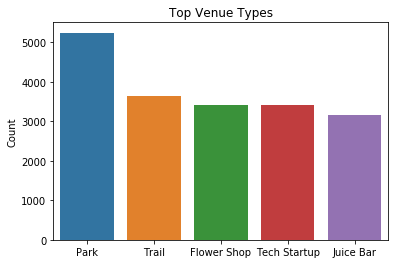

In [64]:
import seaborn as sns
sns.barplot(top_types,top_counts)
plt.title('Top Venue Types')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

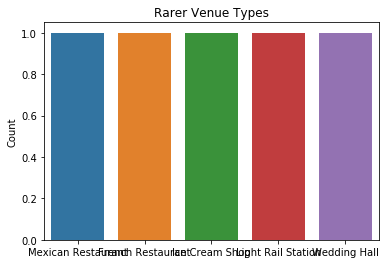

In [65]:
top_types = df.Type.value_counts(ascending=False).tail(5).index
top_counts = df.Type.value_counts(ascending=False).tail(5).values
sns.barplot(top_types,top_counts)
plt.title('Rarer Venue Types')
plt.ylabel('Count')


QC category names - first few 

In [82]:
join2.columns[500:550]

Index(['41st', '420', '4200', '42592', '42°', '43', '43rd', '44', '44)',
       '441,', '444', '445', '44th', '45', '450', '4505', '458', '46', '47',
       '4726', '495', '49th', '4abetteru', '4d', '4ever', '4g',
       '4getmenotsflorist.com', '4greenvision', '4k', '4s', '4th', '5', '5-h',
       '5-mile', '5.0', '5.1', '50', '500', '5000', '505', '509', '51', '515',
       '516', '52', '520', '525', '5280', '53', '53rd'],
      dtype='object')

Need to clean up and drop first few categories

In [90]:
join2.drop(join2.columns[10:651],axis=1,inplace=True)

In [91]:
join2.columns

Index(['Unnamed: 0', 'City', 'CategoryID', 'Venue', 'Latitude', 'Longitude',
       'Type', 'North', 'Venue_tokens', 'West',
       ...
       'Waterfront', 'Wedding Hall', 'Wine Bar', 'Wine Shop', 'Winery',
       'Wings Joint', 'Women's Store', 'Yoga Studio', 'Zoo', 'Zoo Exhibit'],
      dtype='object', length=17954)

#### Step 4 - Modeling Data

In [122]:
join2 = pd.read_csv('Dataset.csv')
join2['West'] = join2.Longitude.map(lambda x: 0 if x > -104 else 1)

In [123]:
join2.drop(['Unnamed: 0','City','CategoryID','Venue','Latitude','Longitude','Type','Venue_tokens'], axis=1,inplace=True)

Format data for modeling step

In [124]:
# Define X and y for this dataset

def Classifier(X, y, class1,class0):

    X = np.asarray(X)


    #from sklearn import preprocessing
    #X = preprocessing.StandardScaler().fit(X).transform(X)


    y = np.asarray(y)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 4)
    print ('Train set:', X_train.shape, y_train.shape)
    print ('Test set:', X_test.shape, y_test.shape)

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix
    LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)


    yhat = LR.predict(X_test)


    yhat_prob = LR.predict_proba(X_test)


    # Compute Jaccard Index

    from sklearn.metrics import jaccard_similarity_score
    print('jaccard score: ',jaccard_similarity_score(y_test, yhat))

    # Confusion Matrix

    from sklearn.metrics import classification_report, confusion_matrix
    import itertools
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
    np.set_printoptions(precision=2)


    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[class1,class0],normalize= False,  title='Confusion matrix')
    print(classification_report(y_test, yhat))

    from sklearn.metrics import log_loss
    log_loss(y_test, yhat_prob)
    
    return 

Train set: (35202, 18585) (35202,)
Test set: (8801, 18585) (8801,)
jaccard score:  0.615043745028974
[[3040 1534]
 [1854 2373]]
Confusion matrix, without normalization
[[3040 1534]
 [1854 2373]]
              precision    recall  f1-score   support

           0       0.61      0.56      0.58      4227
           1       0.62      0.66      0.64      4574

   micro avg       0.62      0.62      0.62      8801
   macro avg       0.61      0.61      0.61      8801
weighted avg       0.61      0.62      0.61      8801



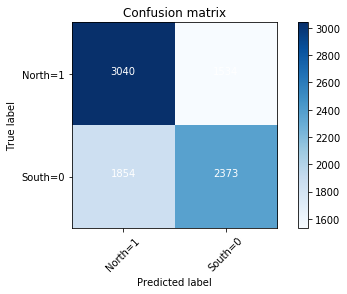

In [125]:
X = join2.drop(['North','West'],axis=1)
y_N_S = join2['North']
Classifier(X, y_N_S, 'North=1','South=0')

Train set: (35202, 18585) (35202,)
Test set: (8801, 18585) (8801,)
jaccard score:  0.63106465174412
[[3385 1297]
 [1950 2169]]
Confusion matrix, without normalization
[[3385 1297]
 [1950 2169]]
              precision    recall  f1-score   support

           0       0.63      0.53      0.57      4119
           1       0.63      0.72      0.68      4682

   micro avg       0.63      0.63      0.63      8801
   macro avg       0.63      0.62      0.62      8801
weighted avg       0.63      0.63      0.63      8801



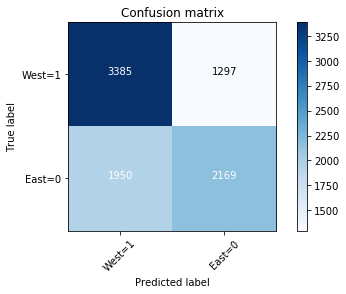

In [126]:
X = join2.drop(['North','West'],axis=1)
y_E_W = join2['West']
Classifier(X, y_E_W,'West=1','East=0')

Train set: (35202, 292) (35202,)
Test set: (8801, 292) (8801,)
jaccard score:  0.55096011816839
[[2964 1610]
 [2342 1885]]
Confusion matrix, without normalization
[[2964 1610]
 [2342 1885]]
              precision    recall  f1-score   support

           0       0.54      0.45      0.49      4227
           1       0.56      0.65      0.60      4574

   micro avg       0.55      0.55      0.55      8801
   macro avg       0.55      0.55      0.54      8801
weighted avg       0.55      0.55      0.55      8801



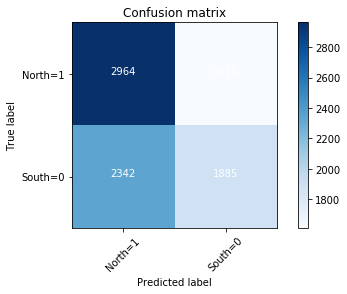

In [127]:
# 3rd model using only venue types

X2 = join2[join2.columns[-len(df.Type.unique()):]]
y_N_S = join2['North']

Classifier(X2, y_N_S,'North=1','South=0')

Train set: (35202, 292) (35202,)
Test set: (8801, 292) (8801,)
jaccard score:  0.5497102601977049
[[3524 1158]
 [2805 1314]]
Confusion matrix, without normalization
[[3524 1158]
 [2805 1314]]
              precision    recall  f1-score   support

           0       0.53      0.32      0.40      4119
           1       0.56      0.75      0.64      4682

   micro avg       0.55      0.55      0.55      8801
   macro avg       0.54      0.54      0.52      8801
weighted avg       0.54      0.55      0.53      8801



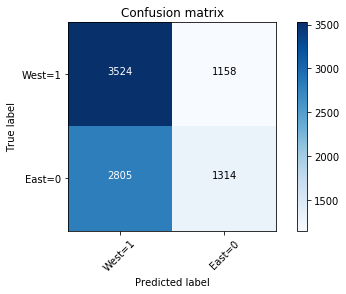

In [128]:
Classifier(X2, y_E_W,'West=1','East=0')

#### Step 5 - Interpretation of Results

There is no significant difference between Model 1 and Model 2. There is higher accuracy at predicting the North and West locations. Models 3 and 4 contain fewer features show less predictive power than Model 1 and 2, but again no significance between 3 and 4. However, the models have predictive power higher than pure chance.

#### Conclusion and Next Steps

This experiment could be improved if more samples are added to the dataset. Further steps could entail of deeper textual analysis, using bigrams and other natural language processing techniques. The premise of the problem, however, it's not very strong to begin with, so the expectations of predictive power of such model should not be high.